In [1]:
%load_ext autoreload
%autoreload 2
!pip install pytorch-lightning==0.7.6 > /dev/null
import pytorch_lightning as pl
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch.nn.functional as F
import math
from scipy.integrate import solve_ivp
import time

%matplotlib inline
#plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
ERROR: Could not find a version that satisfies the requirement pytorch-lightning==0.7.6 (from versions: 0.0.2, 0.5.3, 0.5.3.1)
ERROR: No matching distribution found for pytorch-lightning==0.7.6
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
cpu
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from network import Euler
from Util import *
from DataGenerator import *
from Trainer import *

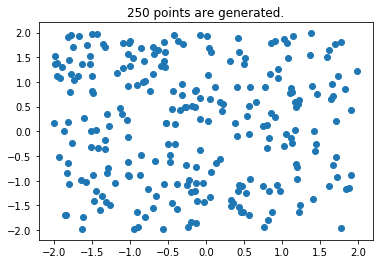

(13426) points are generated


In [3]:
# Generate data for spiral function
def vector_field_spiral(t, x):
    v = [-0.1 * x[0] - 0.5 * x[1], 0.5 * x[0] - 0.1 * x[1]]
    return v

# Sample initial points
num_points = 250
x = np.random.uniform(-2, 2, num_points)
y = np.random.uniform(-2, 2, num_points)
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_title("{} points are generated.".format(num_points))
plt.show()


# Generate Trajectories
duration = 100
DATAPOINTS = None
for i, j in tuple(zip(x, y)):
    trajectory = generate_trajectory_by_ivp([i, j], fun=vector_field_spiral, alpha=None, duration=duration)
    if DATAPOINTS is None:
        DATAPOINTS = trajectory
    else:
        DATAPOINTS = torch.cat([DATAPOINTS, trajectory], dim=0)
print("({}) points are generated".format(len(DATAPOINTS)))

# Train
N = len(DATAPOINTS)  # Size of dataset
M = 2  # input_size
D = 2  # output_size
H = 128  # hidden_size


In [4]:
# TRAIN EULER
model_euler = Eueler(input_size=M, output_size=D, hidden_size=H).to(device)
loss_fn = nn.MSELoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model_euler.parameters(), lr=learning_rate)

num_train, num_val, num_test = int(N * 0.6), int(N * 0.3), int(N * 0.1)

np.random.seed(0)
indices = np.random.permutation(N)
train_idx, val_idx, test_idx = indices[:num_train], indices[num_train:num_train + num_val], indices[
                                                                                            num_train + num_val:]
batch_size = 32
batch_num = np.math.floor(N / batch_size)
batched_train_idxs = np.array_split(train_idx, batch_num)
X = DATAPOINTS[:, :M]
X_1 = DATAPOINTS[:, M:]

epochs = 10

dt = torch.tensor(0.001).to(device).float()
for t in range(epochs):
    train_epoch_loss = 0.0
    seconds = time.time()
    for batch_idx in batched_train_idxs:
        x_0_with_alpha = X[batch_idx].float()
        x_1 = X_1[batch_idx].float()

        y_pred = model_euler(x_0_with_alpha, dt)  # NxM => NxD

        # Compute and print loss.
        loss = loss_fn(y_pred, x_1)
        train_epoch_loss += loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
    train_epoch_loss /= len(train_idx)
    validation_loss = loss_fn(model_euler(X[val_idx].float(), dt), X_1[val_idx].float())
    print('(Epoch %d / %d, seconds: %d) train loss: %f validation loss: %f' % (
        t + 1, epochs, (time.time() - seconds), train_epoch_loss, validation_loss))

(Epoch 1 / 10, seconds: 1) train loss: 0.002421 validation loss: 0.033207
(Epoch 2 / 10, seconds: 1) train loss: 0.001028 validation loss: 0.009443
(Epoch 3 / 10, seconds: 1) train loss: 0.000489 validation loss: 0.008357
(Epoch 4 / 10, seconds: 1) train loss: 0.000475 validation loss: 0.008221
(Epoch 5 / 10, seconds: 1) train loss: 0.000472 validation loss: 0.008159
(Epoch 6 / 10, seconds: 1) train loss: 0.000469 validation loss: 0.008122
(Epoch 7 / 10, seconds: 1) train loss: 0.000467 validation loss: 0.008094
(Epoch 8 / 10, seconds: 1) train loss: 0.000466 validation loss: 0.008069
(Epoch 9 / 10, seconds: 1) train loss: 0.000464 validation loss: 0.008049
(Epoch 10 / 10, seconds: 1) train loss: 0.000463 validation loss: 0.008030


In [5]:
# TRAIN RUNGE KUTTA 4
model_runge = RungeKuttaCompact(input_size=M, output_size=D, hidden_size=H).to(device)
loss_fn = nn.MSELoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model_euler.parameters(), lr=learning_rate)

num_train, num_val, num_test = int(N * 0.6), int(N * 0.3), int(N * 0.1)

np.random.seed(0)
indices = np.random.permutation(N)
train_idx, val_idx, test_idx = indices[:num_train], indices[num_train:num_train + num_val], indices[
                                                                                            num_train + num_val:]
batch_size = 32
batch_num = np.math.floor(N / batch_size)
batched_train_idxs = np.array_split(train_idx, batch_num)
X = DATAPOINTS[:, :M]
X_1 = DATAPOINTS[:, M:]

epochs = 20

dt = torch.tensor(0.01).to(device).float()
for t in range(epochs):
    train_epoch_loss = 0.0
    seconds = time.time()
    for batch_idx in batched_train_idxs:
        x_0_with_alpha = X[batch_idx].float()
        x_1 = X_1[batch_idx].float()

        y_pred = model_euler(x_0_with_alpha, dt)  # NxM => NxD

        # Compute and print loss.
        loss = loss_fn(y_pred, x_1)
        train_epoch_loss += loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
    train_epoch_loss /= len(train_idx)
    validation_loss = loss_fn(model_euler(X[val_idx].float(), dt), X_1[val_idx].float())
    print('(Epoch %d / %d, seconds: %d) train loss: %f validation loss: %f' % (
        t + 1, epochs, (time.time() - seconds), train_epoch_loss, validation_loss))

(Epoch 1 / 20, seconds: 1) train loss: 0.003849 validation loss: 0.030277
(Epoch 2 / 20, seconds: 1) train loss: 0.000744 validation loss: 0.011541
(Epoch 3 / 20, seconds: 1) train loss: 0.000569 validation loss: 0.010758
(Epoch 4 / 20, seconds: 1) train loss: 0.000546 validation loss: 0.010336
(Epoch 5 / 20, seconds: 1) train loss: 0.000530 validation loss: 0.010006
(Epoch 6 / 20, seconds: 1) train loss: 0.000518 validation loss: 0.009735
(Epoch 7 / 20, seconds: 1) train loss: 0.000508 validation loss: 0.009506
(Epoch 8 / 20, seconds: 1) train loss: 0.000499 validation loss: 0.009316
(Epoch 9 / 20, seconds: 1) train loss: 0.000492 validation loss: 0.009152
(Epoch 10 / 20, seconds: 1) train loss: 0.000486 validation loss: 0.009022
(Epoch 11 / 20, seconds: 1) train loss: 0.000481 validation loss: 0.008903
(Epoch 12 / 20, seconds: 1) train loss: 0.000477 validation loss: 0.008808
(Epoch 13 / 20, seconds: 1) train loss: 0.000474 validation loss: 0.008730
(Epoch 14 / 20, seconds: 1) train 

EULER METHOD BY HAND


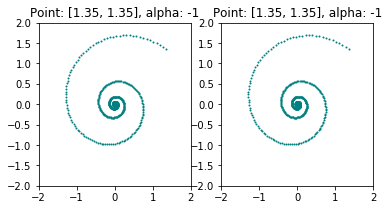

RUNGE KUTTA BY HAND


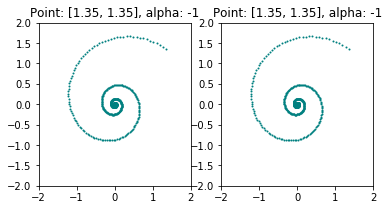

In [6]:
point = [1.35, 1.35]
print("EULER METHOD BY HAND")
trajectory_1 = generate_trajectory_by_euler(fun=vector_field_spiral, start_point=point, alpha=None, duration=100, time_step = 0.1)
visualize_trajectories([trajectory_1,trajectory_1], point, [-1,-1])

print("RUNGE KUTTA BY HAND")
trajectory_1 = generate_trajectory_by_rung4(fun=vector_field_spiral, start_point=point, alpha=None, duration=100, time_step = 0.1)
visualize_trajectories([trajectory_1,trajectory_1], point, [-1,-1])

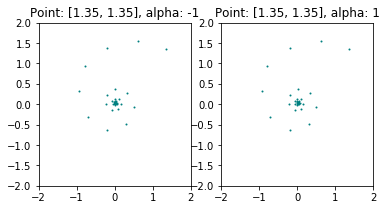

In [7]:
time_step = 0.01
points = np.empty((1, 4))
t = 0
p = np.array(point)

torch_time_step = torch.tensor(time_step).to(device).float()

while t < duration:
    x_1 = model_euler(torch.from_numpy(p.reshape(1, 2)).float(), torch_time_step).detach().numpy()

    row = np.append(p, x_1).reshape(1, 4)

    points = np.vstack((points, row))

    p = x_1
    t += time_step
    
trajectory_1 = torch.from_numpy(points).float()
visualize_trajectories([trajectory_1,trajectory_1], point, [-1,1])